# Neural Network classification with PyTorch

classification is a problem of predicting whether something is one thing or another (detect what type of food it is).

## 1. Make classification data and get it ready

In [1]:
import sklearn
from fontTools.ttLib.tables._c_m_a_p import cmap_format_0
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [2]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [3]:
y[:5]

array([1, 1, 1, 1, 0], dtype=int64)

### Analyze the generated data using `pandas`

In [4]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label (y)": y})

circles.head(10)

,X1,X2,label (y)
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


### Viualyze the generated data using `Mathplotlib`

In [5]:
import matplotlib.pyplot as plt

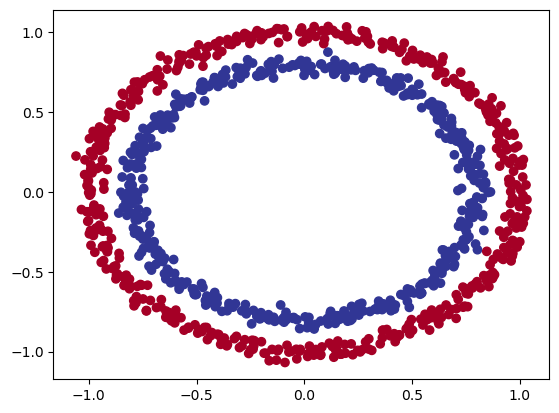

In [6]:
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu
)

**Toy dataset**: dataset that is small enough to experiment but still sizeable enough to practice the fundamentals with.

### Check input and output shape

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

### Turn data into tensors

In [8]:
import torch

torch.__version__

'2.0.0+cpu'

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X[: 5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

### Split data into training and test sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

lets build a model to classify our blue and red dots.

To do this we want:
1. Setup up device agnostic code
2. construct a model by subclassing `nn.Module`
3. Pich a loss and optimizer
4. create a training and test loop

### Setup device agnostic code

In [13]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Construct a model

To create a model:
1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` layers, so that they can handle our data
3. Define a `forward()` method that outlines the forward pass
4. Instatieate an instance of our model class and send it to the device.

In [14]:
class CircleModelV01(nn.Module):
    def __init__(self):
        super().__init__()

        # The more feature the more capabilities to learn. This does whoever have a limit of usefullniss
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # takes in two numbers and upscales to five numbers
        self.layer_2 = nn.Linear(in_features=5,
                                 out_features=1)  # takes in the five numbers from the previous and outputs one. (the same shaper as Y)

        # methode outlines the forward pass

    def forward(self, x):
        # x -> layer 1 -> layer 2 -> output
        return self.layer_2(self.layer_1(x))


model_0 = CircleModelV01().to(device)

model_0

CircleModelV01(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cpu')

### Model network using nn.sequential

In [16]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2836, -0.5918],
                      [-0.5914, -0.0287],
                      [ 0.6013, -0.1253],
                      [ 0.0968,  0.4349],
                      [-0.5275,  0.2971]])),
             ('layer_1.bias',
              tensor([-0.1358, -0.0271,  0.2561, -0.6230, -0.4016])),
             ('layer_2.weight',
              tensor([[-0.0039, -0.3046,  0.3450,  0.2736, -0.3201]])),
             ('layer_2.bias', tensor([0.1522]))])

### Setup loss function and optimizer

The loss and optemizers are problem specific. for a table look in the course 02.2.1

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a remainder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of most common are SGC and Adam, but pyton has a lot more build in.

For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`

In [17]:
loss_fn = nn.BCEWithLogitsLoss()  # loss function with sigmoid activation function build in

optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

### Calculate accuracy

In [18]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train a model

to train a model we need a training model.

1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### Raw logits -> prediction probabilities -> prediction labels

our model outputs are going to be raw **logits**, these can be converted in to prediction probabilities by passing them to some kind of activation function.
* For binary -> sigmoid
* For multi class -> softmax

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`


In [19]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0165],
        [ 0.2084],
        [-0.1988],
        [ 0.0334],
        [ 0.4477]])

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

These two are not of the same format, to get them in the same function we are going to use the sigmoid activation function.

In [21]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4959],
        [0.5519],
        [0.4505],
        [0.5084],
        [0.6101]])

In [22]:
torch.round(y_pred_probs)

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.]])

To get the labesl we do an if on the rounded number
* `y_preds_probs` >= 0.5, then `y=1` (class 1)
* `y_preds_probs` < 0.5, then `y=0` (class 0)

In [23]:
y_preds = torch.round(y_pred_probs)

# In full (lodgits -> pred probs -> pred labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 1., 0., 1., 1.])

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

Now our output data and our test data are in the same format

### building a training and test loop

In [25]:
model = model_0

epoches: int = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoches):
    model.train()

    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calcultae loss
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # for nn.BCEloss does not lodgits

    # We usualy do this with preds but our loss functions expect lodgits
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_train, y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer.step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate test loss/ac
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71426 | Acc: 51.75% | Test loss: 0.71993 | Test acc: 50.50%
Epoch: 10 | Loss: 0.70597 | Acc: 51.00% | Test loss: 0.71241 | Test acc: 51.50%
Epoch: 20 | Loss: 0.70189 | Acc: 51.00% | Test loss: 0.70852 | Test acc: 49.00%
Epoch: 30 | Loss: 0.69957 | Acc: 50.75% | Test loss: 0.70616 | Test acc: 48.00%
Epoch: 40 | Loss: 0.69810 | Acc: 50.88% | Test loss: 0.70456 | Test acc: 48.50%
Epoch: 50 | Loss: 0.69707 | Acc: 50.62% | Test loss: 0.70337 | Test acc: 48.50%
Epoch: 60 | Loss: 0.69631 | Acc: 50.12% | Test loss: 0.70244 | Test acc: 49.50%
Epoch: 70 | Loss: 0.69573 | Acc: 50.25% | Test loss: 0.70169 | Test acc: 48.50%
Epoch: 80 | Loss: 0.69528 | Acc: 50.62% | Test loss: 0.70107 | Test acc: 49.00%
Epoch: 90 | Loss: 0.69493 | Acc: 50.12% | Test loss: 0.70056 | Test acc: 47.50%


## 4. Make predictions and evaluate model

it looks like the model is not learning anything. Let's inspect the model and make some predictions. try and get this function working from other file.

In [26]:
import numpy as np


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

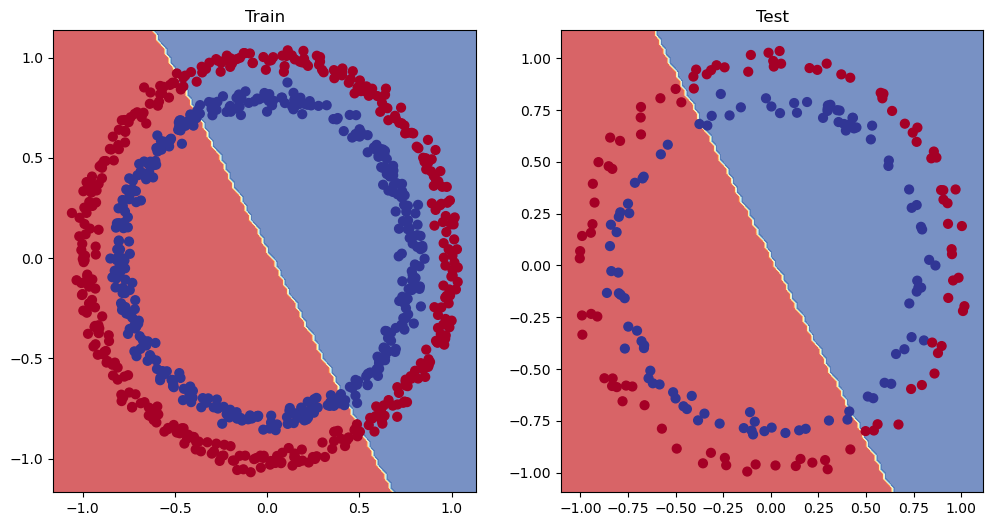

In [27]:
# from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

As seen above the model tries to draw the wrong line. we should not use liniear layers.

## 5. Improve model

There are a couple of ways to improve a model
* Adding more layers
* Adding hidden units.
* Train for longer
* Changing the activation functions
* Change the learnign rate
* Change the loss function

All these things can be changed through hyper parameters

In [28]:
class CircleModelV02(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV02().to(device)

In [29]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [30]:
torch.manual_seed(72)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuratie
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    # 3. Optimize zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():

        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69337 | Acc: 57.50% | Test loss: 0.69335 | Test acc: 55.50%
Epoch: 100 | Loss: 0.69305 | Acc: 51.50% | Test loss: 0.69382 | Test acc: 47.50%
Epoch: 200 | Loss: 0.69300 | Acc: 51.00% | Test loss: 0.69418 | Test acc: 46.50%
Epoch: 300 | Loss: 0.69299 | Acc: 51.12% | Test loss: 0.69440 | Test acc: 47.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.25% | Test loss: 0.69453 | Test acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.62% | Test loss: 0.69460 | Test acc: 45.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.38% | Test loss: 0.69464 | Test acc: 45.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.25% | Test loss: 0.69466 | Test acc: 45.00%
Epoch: 800 | Loss: 0.69298 | Acc: 51.12% | Test loss: 0.69467 | Test acc: 45.50%
Epoch: 900 | Loss: 0.69298 | Acc: 51.12% | Test loss: 0.69467 | Test acc: 46.00%


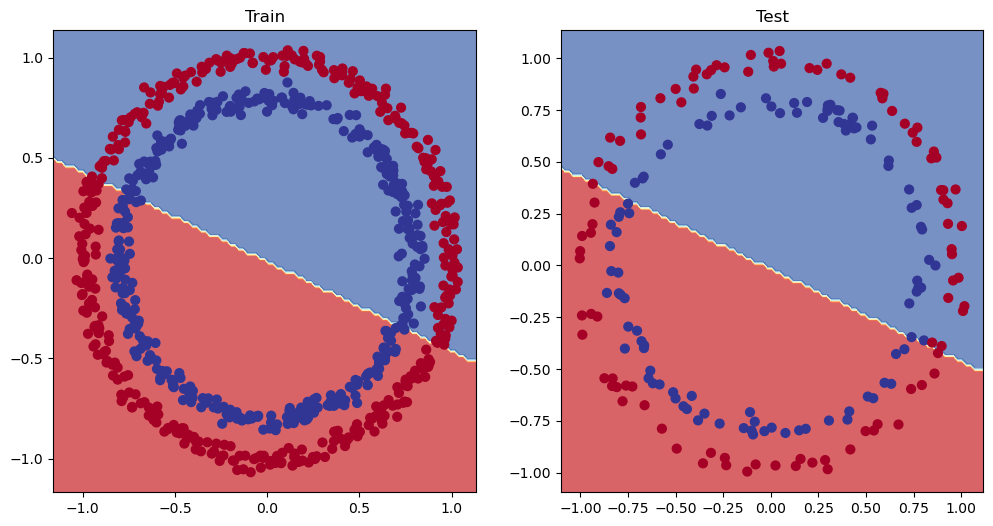

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to trouble shoot to a larger problem is to test out a smaller problem

In [ ]:
# Create some data (same as nootbook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regrssion =